# Tokenizers, word embeddings, sentence embeddings

## Setup and Imports

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

/opt/miniconda3/envs/re/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Choosing the Right Device (CPU or MPS)
We use Apple Silicon's MPS (Metal backend) if available for faster inference.

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # use 'cuda' if GPU is available for you
print(f"Using device: {device}")

Using device: mps


## Loading Phi-3 Mini Model (Instruction-Tuned)
Phi-3 is a small yet powerful LLM released by Microsoft. It's ideal for CPU/MPS inference and demo setups.

In [5]:
model = AutoModelForCausalLM.from_pretrained(
    'microsoft/Phi-3-mini-4k-instruct',
    torch_dtype=torch.float32,
    trust_remote_code=True
).to(device)

tokenizer = AutoTokenizer.from_pretrained('microsoft/Phi-3-mini-4k-instruct')

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:07<00:00,  3.54s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Generation with Prompt

In [6]:
# Prompt we send to the model — it's an instruction asking the assistant to write an apology email.
# The <|assistant|> token signals where the model should start generating its response.
# It's a special token used by instruction-tuned models to simulate conversational format.

prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened. <|assistant|>"

# Tokenize the input prompt and convert to PyTorch tensors.
# We move the tensors to the appropriate device (MPS or CPU).
inputs = tokenizer(prompt, return_tensors='pt').to(device)

# Generate a response using the model.
# `max_new_tokens=20` limits the number of tokens generated (for speed/demo purposes).
# `attention_mask` is required on Apple Silicon (MPS) to avoid errors during generation.
generation_output = model.generate(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_new_tokens=50
)

# Decode the output tokens back to readable text.
# `skip_special_tokens=True` removes tokens like <|endoftext|> or <|assistant|> from the output.
print(tokenizer.decode(generation_output[0], skip_special_tokens=True))

You are not running the flash-attention implementation, expect numerical differences.


Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened.  Subject: Heartfelt Apologies for the Gardening Mishap


Dear Sarah,


I hope this message finds you well. I am writing to express my deepest apologies for the unfortunate incident that


## Token-Level Insight: Decoding Individual Token IDs
This helps visualize how a sentence is split into meaningful or subword tokens (like "apolog", "izing").

In [5]:
for token_id in inputs['input_ids'][0]:
    print(tokenizer.decode(token_id))

Write
an
email
apolog
izing
to
Sarah
for
the
trag
ic
garden
ing
m
ish
ap
.
Exp
lain
how
it
happened
.

<|assistant|>


## Visual Tokenizer Comparison

In [6]:
text = """
English and CAPITALIZATION
🎵 鸟
show_tokens False None elif == >= else: two tabs:"    " Three tabs: "       "
12.0*50=600
"""
from transformers import AutoTokenizer
colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]
def show_tokens(sentence, tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    token_ids = tokenizer(sentence).input_ids
    for idx, t in enumerate(token_ids):
        print(
            f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m' +
            tokenizer.decode(t) +
            '\x1b[0m',
            end=' '
        )

In [18]:
show_tokens(text, "bert-base-uncased")

[CLS] english and capital ##ization [UNK] [UNK] show _ token ##s false none eli ##f = = > = else : two tab ##s : " " three tab ##s : " " 12 . 0 * 50 = 600 [SEP] 

In [19]:
show_tokens(text, "bert-base-cased")

[CLS] English and CA ##PI ##TA ##L ##I ##Z ##AT ##ION [UNK] [UNK] show _ token ##s F ##als ##e None el ##if = = > = else : two ta ##bs : " " Three ta ##bs : " " 12 . 0 * 50 = 600 [SEP] 

In [20]:
show_tokens(text, "gpt2")


 English  and  CAP ITAL IZ ATION 
 � � �  � � � 
 show _ t ok ens  False  None  el if  ==  >=  else :  two  tabs :"        "  Three  tabs :  "              " 
 12 . 0 * 50 = 600 
 

In [21]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
token_ids = tokenizer(text).input_ids
print(token_ids[8:11])
print(tokenizer.decode(token_ids[8:11]))

[8582, 236, 113]
🎵


In [22]:
show_tokens(text, "bigcode/starcoder2-15b")


 English  and  CAPITAL IZATION 
 � � �   � � 
 show _ tokens  False  None  elif  ==  >=  else :  two  tabs :"      "  Three  tabs :  "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [23]:
show_tokens(text, "facebook/galactica-1.3b")


 English  and  CAP ITAL IZATION 
 � � � �  � � � 
 show _ tokens  False  None  elif   ==   > =  else :  two  t abs : "      "  Three  t abs :   "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [24]:
show_tokens(text, "microsoft/Phi-3-mini-4k-instruct")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


 
 English and C AP IT AL IZ ATION 
 � � � �  � � � 
 show _ to kens False None elif == >= else : two tabs :"    " Three tabs : "       " 
 1 2 . 0 * 5 0 = 6 0 0 
 

## Contextual Embeddings Demo (with DeBERTa)

In [7]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('microsoft/deberta-v3-xsmall', torch_dtype=torch.float32).to(device)
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
tokens = tokenizer('Hello World', return_tensors='pt').to(device)
output = model(**tokens)[0]
print(output.shape)

torch.Size([1, 4, 384])


## Sentence Embeddings (with SentenceTransformers)

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to(device)
vector = model.encode("Best movie ever")
print(vector.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/miniconda3/envs/re/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(768,)


## Classic Word Embeddings (GloVe Example)

In [9]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")
print(model.most_similar([model['king']], topn=10))

[('king', 1.0000001192092896), ('prince', 0.8236179351806641), ('queen', 0.7839044332504272), ('ii', 0.7746230363845825), ('emperor', 0.7736247777938843), ('son', 0.766719400882721), ('uncle', 0.7627150416374207), ('kingdom', 0.7542160749435425), ('throne', 0.7539914846420288), ('brother', 0.7492412328720093)]


## Extra: Visualize Embedding Similarity with Cosine Distance

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def print_similarity(word1, word2):
    vec1 = model[word1].reshape(1, -1)
    vec2 = model[word2].reshape(1, -1)
    sim = cosine_similarity(vec1, vec2)[0][0]
    print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")

print_similarity('king', 'queen')
print_similarity('king', 'dog')

Similarity between 'king' and 'queen': 0.7839
Similarity between 'king' and 'dog': 0.3405


## Extension 1: Compare Output Across Temperatures

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    torch_dtype=torch.float32,
    trust_remote_code=True
).to(device)

prompt = "Explain word embeddings to a 5-year-old. <|assistant|>"
temperatures = [0.2, 0.6, 1.0]

for temp in temperatures:
    print(f"\n\033[1m--- Output with temperature={temp} ---\033[0m")
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    output = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_new_tokens=50,
        temperature=temp,
        do_sample=True
    )
    print(tokenizer.decode(output[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:17<00:00,  8.63s/it]



--- Output with temperature=0.2 ---
Explain word embeddings to a 5-year-old.  Imagine you have a big book where every word is a little picture. These pictures show what the words mean, like how a picture of a dog shows us a dog. Now, word embeddings are like a super-smart way to

--- Output with temperature=0.6 ---
Explain word embeddings to a 5-year-old.  Imagine every word in the English language is like a different color in a giant rainbow. Now, think of word embeddings as a magical paintbrush that can paint words with their colors, but not just any color – it cho

--- Output with temperature=1.0 ---
Explain word embeddings to a 5-year-old.  Imagine you have a magical book, where every animal on Earth has its own picture. But, if you wanted to understand what makes a dog a dog or a cat a cat, you might look at their pictures and see that they both have


## Extension 2: Visualize Word Embedding Similarity in 2D (using GloVe)

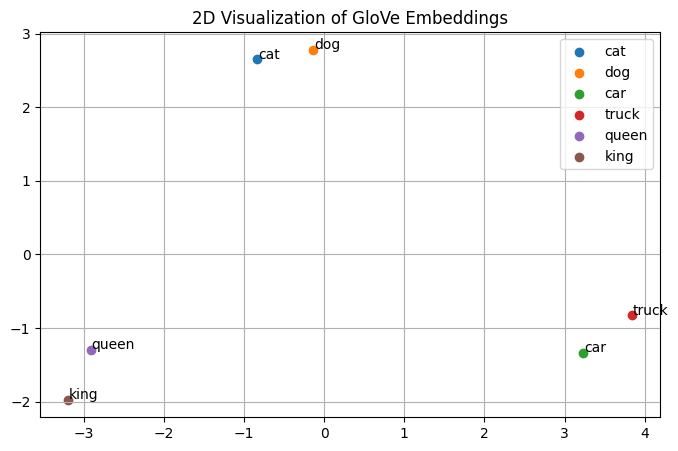

In [16]:
import gensim.downloader as api
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

glove_model = api.load("glove-wiki-gigaword-50")
words = ["cat", "dog", "car", "truck", "queen", "king"]
word_vectors = [glove_model[word] for word in words]
pca = PCA(n_components=2)
points = pca.fit_transform(word_vectors)

plt.figure(figsize=(8, 5))
for i, word in enumerate(words):
    plt.scatter(*points[i], label=word)
    plt.text(points[i, 0]+0.01, points[i, 1]+0.01, word)
plt.title("2D Visualization of GloVe Embeddings")
plt.legend()
plt.grid(True)
plt.show()

## Extension 3: Compare Sentence Embeddings with Similarity Heatmap (SentenceTransformers)

/opt/miniconda3/envs/re/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


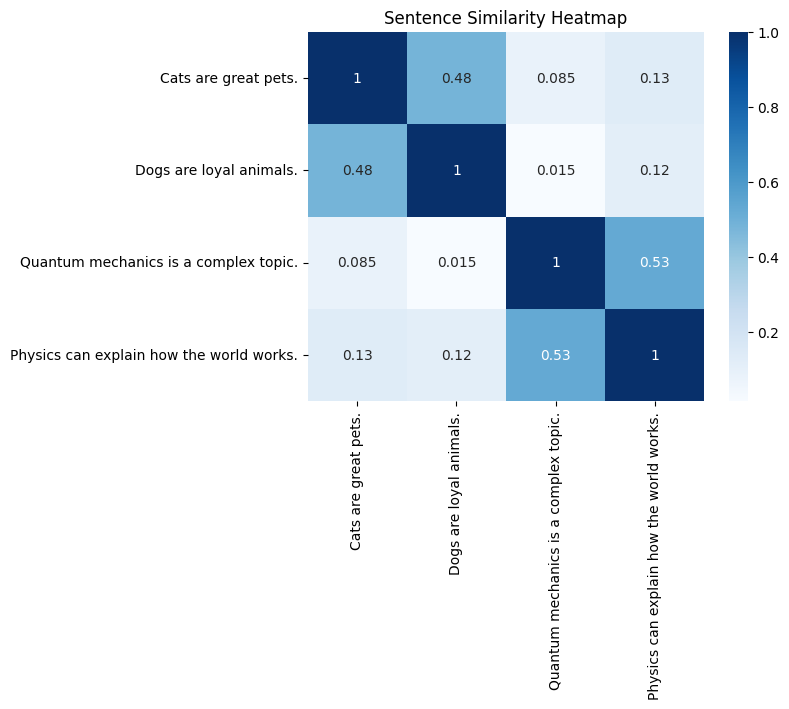

In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

sentences = [
    "Cats are great pets.",
    "Dogs are loyal animals.",
    "Quantum mechanics is a complex topic.",
    "Physics can explain how the world works."
]

embed_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to(device)
embeddings = embed_model.encode(sentences)
sim_matrix = cosine_similarity(embeddings)

sns.heatmap(sim_matrix, annot=True, xticklabels=sentences, yticklabels=sentences, cmap="Blues")
plt.title("Sentence Similarity Heatmap")
plt.show()

In [1]:
# MPS Memory Cleanup for Apple Silicon (macOS)
def cleanup_mps_memory():
    """
    Frees MPS memory by deleting global variables 'model' and 'tokenizer' if they exist.
    Useful when you want to avoid passing model/tokenizer manually.
    """
    import gc
    import torch

    for var in ['model', 'tokenizer']:
        if var in globals():
            print(f"🔹 Deleting: {var}")
            del globals()[var]

    gc.collect()
    torch.mps.empty_cache()
    print("MPS memory cleaned.")

In [2]:
cleanup_mps_memory()

MPS memory cleaned.


## Final Notes
- Based on Chapter 2 of *Hands-On LLMs* (Jay Alammar & Maarten Grootendorst)
- Extended with visualizations and experiments by Mayia Samuilik

Resources:
- Phi-3: https://huggingface.co/microsoft/Phi-3-mini-4k-instruct
- GloVe: https://nlp.stanford.edu/projects/glove/
- Sentence Transformers: https://www.sbert.net/